In [2]:
# rnnlm_gen.py

# coding: utf-8
import sys
sys.path.append('..')
import numpy as np
from common.functions import softmax
from ch6.rnnlm import Rnnlm
from ch6.better_rnnlm import BetterRnnlm


class RnnlmGen(Rnnlm):
    def generate(self, start_id, skip_ids=None, sample_size=100):
        word_ids = [start_id]

        x = start_id
        while len(word_ids) < sample_size:
            x = np.array(x).reshape(1, 1)
            score = self.predict(x)
            p = softmax(score.flatten())

            sampled = np.random.choice(len(p), size=1, p=p)
            if (skip_ids is None) or (sampled not in skip_ids):
                x = sampled
                word_ids.append(int(x))

        return word_ids

    def get_state(self):
        return self.lstm_layer.h, self.lstm_layer.c

    def set_state(self, state):
        self.lstm_layer.set_state(*state)


class BetterRnnlmGen(BetterRnnlm):
    def generate(self, start_id, skip_ids=None, sample_size=100):
        word_ids = [start_id]

        x = start_id
        while len(word_ids) < sample_size:
            x = np.array(x).reshape(1, 1)
            score = self.predict(x).flatten()
            p = softmax(score).flatten()

            sampled = np.random.choice(len(p), size=1, p=p)
            if (skip_ids is None) or (sampled not in skip_ids):
                x = sampled
                word_ids.append(int(x))

        return word_ids

    def get_state(self):
        states = []
        for layer in self.lstm_layers:
            states.append((layer.h, layer.c))
        return states

    def set_state(self, states):
        for layer, state in zip(self.lstm_layers, states):
            layer.set_state(*state)

In [25]:
# coding: utf-8
import sys
sys.path.append('..')
from dataset import ptb


corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)
corpus_size = len(corpus)

model = RnnlmGen()
model.load_params('../ch6/Rnnlm.pkl')

# start 문자와 skip 문자 설정
start_word = 'you'
start_id = word_to_id[start_word]
skip_words = ['N', '<unk>', '$']
skip_ids = [word_to_id[w] for w in skip_words]
# 문장 생성
word_ids = model.generate(start_id, skip_ids)
txt = ' '.join([id_to_word[i] for i in word_ids])
txt = txt.replace(' <eos>', '.\n')
print(txt)

OSError: No file: ..\ch6\Rnnlm.pkl

In [24]:
# coding: utf-8
import sys
sys.path.append('..')
from common.np import *
from dataset import ptb


corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)
corpus_size = len(corpus)


model = BetterRnnlmGen()
model.load_params('../ch6/BetterRnnlm.pkl')

# start 문자와 skip 문자 설정
start_word = 'you'
start_id = word_to_id[start_word]
skip_words = ['N', '<unk>', '$']
skip_ids = [word_to_id[w] for w in skip_words]
# 문장 생성
word_ids = model.generate(start_id, skip_ids)
txt = ' '.join([id_to_word[i] for i in word_ids])
txt = txt.replace(' <eos>', '.\n')

print(txt)


model.reset_state()

start_words = 'the meaning of life is'
start_ids = [word_to_id[w] for w in start_words.split(' ')]

for x in start_ids[:-1]:
    x = np.array(x).reshape(1, 1)
    model.predict(x)

word_ids = model.generate(start_ids[-1], skip_ids)
word_ids = start_ids[:-1] + word_ids
txt = ' '.join([id_to_word[i] for i in word_ids])
txt = txt.replace(' <eos>', '.\n')
print('-' * 50)
print(txt)

OSError: No file: ..\ch6\BetterRnnlm.pkl

In [27]:
# coding: utf-8
import sys
sys.path.append('..')
from common.time_layers import *
from common.base_model import BaseModel


class Encoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')

        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=False)

        self.params = self.embed.params + self.lstm.params
        self.grads = self.embed.grads + self.lstm.grads
        self.hs = None

    def forward(self, xs):
        xs = self.embed.forward(xs)
        hs = self.lstm.forward(xs)
        self.hs = hs
        return hs[:, -1, :]

    def backward(self, dh):
        dhs = np.zeros_like(self.hs)
        dhs[:, -1, :] = dh

        dout = self.lstm.backward(dhs)
        dout = self.embed.backward(dout)
        return dout


class Decoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True)
        self.affine = TimeAffine(affine_W, affine_b)

        self.params, self.grads = [], []
        for layer in (self.embed, self.lstm, self.affine):
            self.params += layer.params
            self.grads += layer.grads

    def forward(self, xs, h):
        self.lstm.set_state(h)

        out = self.embed.forward(xs)
        out = self.lstm.forward(out)
        score = self.affine.forward(out)
        return score

    def backward(self, dscore):
        dout = self.affine.backward(dscore)
        dout = self.lstm.backward(dout)
        dout = self.embed.backward(dout)
        dh = self.lstm.dh
        return dh

    def generate(self, h, start_id, sample_size):
        sampled = []
        sample_id = start_id
        self.lstm.set_state(h)

        for _ in range(sample_size):
            x = np.array(sample_id).reshape((1, 1))
            out = self.embed.forward(x)
            out = self.lstm.forward(out)
            score = self.affine.forward(out)

            sample_id = np.argmax(score.flatten())
            sampled.append(int(sample_id))

        return sampled


class Seq2seq(BaseModel):
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        self.encoder = Encoder(V, D, H)
        self.decoder = Decoder(V, D, H)
        self.softmax = TimeSoftmaxWithLoss()

        self.params = self.encoder.params + self.decoder.params
        self.grads = self.encoder.grads + self.decoder.grads

    def forward(self, xs, ts):
        decoder_xs, decoder_ts = ts[:, :-1], ts[:, 1:]

        h = self.encoder.forward(xs)
        score = self.decoder.forward(decoder_xs, h)
        loss = self.softmax.forward(score, decoder_ts)
        return loss

    def backward(self, dout=1):
        dout = self.softmax.backward(dout)
        dh = self.decoder.backward(dout)
        dout = self.encoder.backward(dh)
        return dout

    def generate(self, xs, start_id, sample_size):
        h = self.encoder.forward(xs)
        sampled = self.decoder.generate(h, start_id, sample_size)
        return sampled

| 에폭 1 |  반복 1 / 351 | 시간 0[s] | 손실 2.56
| 에폭 1 |  반복 21 / 351 | 시간 0[s] | 손실 2.53
| 에폭 1 |  반복 41 / 351 | 시간 0[s] | 손실 2.17
| 에폭 1 |  반복 61 / 351 | 시간 0[s] | 손실 1.96
| 에폭 1 |  반복 81 / 351 | 시간 1[s] | 손실 1.92
| 에폭 1 |  반복 101 / 351 | 시간 1[s] | 손실 1.87
| 에폭 1 |  반복 121 / 351 | 시간 1[s] | 손실 1.85
| 에폭 1 |  반복 141 / 351 | 시간 1[s] | 손실 1.83
| 에폭 1 |  반복 161 / 351 | 시간 2[s] | 손실 1.79
| 에폭 1 |  반복 181 / 351 | 시간 2[s] | 손실 1.77
| 에폭 1 |  반복 201 / 351 | 시간 2[s] | 손실 1.77
| 에폭 1 |  반복 221 / 351 | 시간 2[s] | 손실 1.76
| 에폭 1 |  반복 241 / 351 | 시간 3[s] | 손실 1.76
| 에폭 1 |  반복 261 / 351 | 시간 3[s] | 손실 1.76
| 에폭 1 |  반복 281 / 351 | 시간 3[s] | 손실 1.75
| 에폭 1 |  반복 301 / 351 | 시간 3[s] | 손실 1.74
| 에폭 1 |  반복 321 / 351 | 시간 3[s] | 손실 1.75
| 에폭 1 |  반복 341 / 351 | 시간 4[s] | 손실 1.74
Q 77+85  
T 162 
X 100 
---
Q 975+164
T 1139
X 1000
---
Q 582+84 
T 666 
X 1000
---
Q 8+155  
T 163 
X 100 
---
Q 367+55 
T 422 
X 1000
---
Q 600+257
T 857 
X 1000
---
Q 761+292
T 1053
X 1000
---
Q 830+597
T 1427
X 1000
---
Q 26+838

검증 정확도 3.880%
| 에폭 9 |  반복 1 / 351 | 시간 0[s] | 손실 0.99
| 에폭 9 |  반복 21 / 351 | 시간 0[s] | 손실 1.00
| 에폭 9 |  반복 41 / 351 | 시간 0[s] | 손실 1.00
| 에폭 9 |  반복 61 / 351 | 시간 0[s] | 손실 1.00
| 에폭 9 |  반복 81 / 351 | 시간 0[s] | 손실 0.99
| 에폭 9 |  반복 101 / 351 | 시간 1[s] | 손실 0.99
| 에폭 9 |  반복 121 / 351 | 시간 1[s] | 손실 1.00
| 에폭 9 |  반복 141 / 351 | 시간 1[s] | 손실 1.04
| 에폭 9 |  반복 161 / 351 | 시간 1[s] | 손실 1.03
| 에폭 9 |  반복 181 / 351 | 시간 1[s] | 손실 1.02
| 에폭 9 |  반복 201 / 351 | 시간 2[s] | 손실 1.02
| 에폭 9 |  반복 221 / 351 | 시간 2[s] | 손실 1.01
| 에폭 9 |  반복 241 / 351 | 시간 2[s] | 손실 1.02
| 에폭 9 |  반복 261 / 351 | 시간 2[s] | 손실 1.02
| 에폭 9 |  반복 281 / 351 | 시간 3[s] | 손실 0.99
| 에폭 9 |  반복 301 / 351 | 시간 3[s] | 손실 0.98
| 에폭 9 |  반복 321 / 351 | 시간 3[s] | 손실 0.98
| 에폭 9 |  반복 341 / 351 | 시간 3[s] | 손실 0.97
Q 77+85  
T 162 
X 161 
---
Q 975+164
T 1139
X 1121
---
Q 582+84 
T 666 
X 668 
---
Q 8+155  
T 163 
X 158 
---
Q 367+55 
T 422 
X 418 
---
Q 600+257
T 857 
X 848 
---
Q 761+292
T 1053
X 1039
---
Q 830+597
T 1427
X 141

| 에폭 16 |  반복 321 / 351 | 시간 3[s] | 손실 0.86
| 에폭 16 |  반복 341 / 351 | 시간 3[s] | 손실 0.85
Q 77+85  
T 162 
X 161 
---
Q 975+164
T 1139
X 1120
---
Q 582+84 
T 666 
X 662 
---
Q 8+155  
T 163 
O 163 
---
Q 367+55 
T 422 
X 419 
---
Q 600+257
T 857 
X 849 
---
Q 761+292
T 1053
X 1039
---
Q 830+597
T 1427
X 1418
---
Q 26+838 
T 864 
X 859 
---
Q 143+93 
T 236 
X 239 
---
검증 정확도 7.580%
| 에폭 17 |  반복 1 / 351 | 시간 0[s] | 손실 0.84
| 에폭 17 |  반복 21 / 351 | 시간 0[s] | 손실 0.84
| 에폭 17 |  반복 41 / 351 | 시간 0[s] | 손실 0.86
| 에폭 17 |  반복 61 / 351 | 시간 0[s] | 손실 0.84
| 에폭 17 |  반복 81 / 351 | 시간 0[s] | 손실 0.84
| 에폭 17 |  반복 101 / 351 | 시간 1[s] | 손실 0.83
| 에폭 17 |  반복 121 / 351 | 시간 1[s] | 손실 0.92
| 에폭 17 |  반복 141 / 351 | 시간 1[s] | 손실 0.88
| 에폭 17 |  반복 161 / 351 | 시간 1[s] | 손실 0.87
| 에폭 17 |  반복 181 / 351 | 시간 2[s] | 손실 0.88
| 에폭 17 |  반복 201 / 351 | 시간 2[s] | 손실 0.87
| 에폭 17 |  반복 221 / 351 | 시간 2[s] | 손실 0.86
| 에폭 17 |  반복 241 / 351 | 시간 2[s] | 손실 0.87
| 에폭 17 |  반복 261 / 351 | 시간 3[s] | 손실 0.85
| 에폭 17 

| 에폭 24 |  반복 121 / 351 | 시간 1[s] | 손실 0.75
| 에폭 24 |  반복 141 / 351 | 시간 1[s] | 손실 0.76
| 에폭 24 |  반복 161 / 351 | 시간 1[s] | 손실 0.77
| 에폭 24 |  반복 181 / 351 | 시간 2[s] | 손실 0.76
| 에폭 24 |  반복 201 / 351 | 시간 2[s] | 손실 0.76
| 에폭 24 |  반복 221 / 351 | 시간 2[s] | 손실 0.83
| 에폭 24 |  반복 241 / 351 | 시간 2[s] | 손실 0.80
| 에폭 24 |  반복 261 / 351 | 시간 2[s] | 손실 0.76
| 에폭 24 |  반복 281 / 351 | 시간 3[s] | 손실 0.77
| 에폭 24 |  반복 301 / 351 | 시간 3[s] | 손실 0.80
| 에폭 24 |  반복 321 / 351 | 시간 3[s] | 손실 0.78
| 에폭 24 |  반복 341 / 351 | 시간 3[s] | 손실 0.77
Q 77+85  
T 162 
X 161 
---
Q 975+164
T 1139
X 1151
---
Q 582+84 
T 666 
X 661 
---
Q 8+155  
T 163 
X 157 
---
Q 367+55 
T 422 
X 417 
---
Q 600+257
T 857 
X 849 
---
Q 761+292
T 1053
X 1039
---
Q 830+597
T 1427
X 1418
---
Q 26+838 
T 864 
X 857 
---
Q 143+93 
T 236 
X 229 
---
검증 정확도 8.780%
| 에폭 25 |  반복 1 / 351 | 시간 0[s] | 손실 0.78
| 에폭 25 |  반복 21 / 351 | 시간 0[s] | 손실 0.77
| 에폭 25 |  반복 41 / 351 | 시간 0[s] | 손실 0.77
| 에폭 25 |  반복 61 / 351 | 시간 0[s] | 손실 0.77
| 에폭 25

C:\Users\ksj31\anaconda3\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 50640 (\N{HANGUL SYLLABLE E}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\ksj31\anaconda3\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 54253 (\N{HANGUL SYLLABLE POG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\ksj31\anaconda3\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\ksj31\anaconda3\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 54869 (\N{HANGUL SYLLABLE HWAG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\ksj31\anaconda3\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


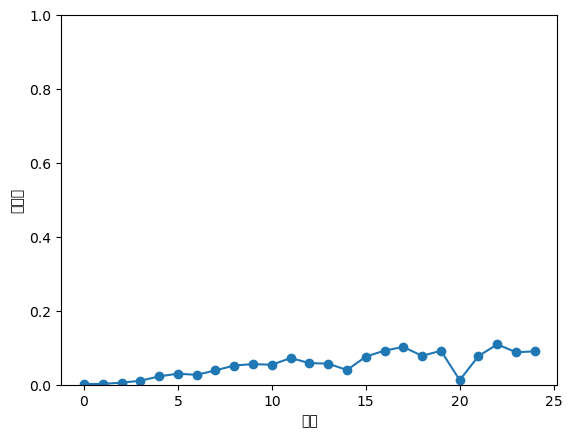

In [29]:
# coding: utf-8
import sys
sys.path.append('..')
import numpy as np
import matplotlib.pyplot as plt
from dataset import sequence
from common.optimizer import Adam
from common.trainer import Trainer
from common.util import eval_seq2seq


# 데이터셋 읽기
(x_train, t_train), (x_test, t_test) = sequence.load_data('addition.txt')
char_to_id, id_to_char = sequence.get_vocab()

# 입력 반전 여부 설정 =============================================
is_reverse = False  # True
if is_reverse:
    x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]
# ================================================================

# 하이퍼파라미터 설정
vocab_size = len(char_to_id)
wordvec_size = 16
hidden_size = 128
batch_size = 128
max_epoch = 25
max_grad = 5.0

# 일반 혹은 엿보기(Peeky) 설정 =====================================
model = Seq2seq(vocab_size, wordvec_size, hidden_size)
# model = PeekySeq2seq(vocab_size, wordvec_size, hidden_size)
# ================================================================
optimizer = Adam()
trainer = Trainer(model, optimizer)

acc_list = []
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train, max_epoch=1,
                batch_size=batch_size, max_grad=max_grad)

    correct_num = 0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i < 10
        correct_num += eval_seq2seq(model, question, correct,
                                    id_to_char, verbose, is_reverse)

    acc = float(correct_num) / len(x_test)
    acc_list.append(acc)
    print('검증 정확도 %.3f%%' % (acc * 100))

# 그래프 그리기
x = np.arange(len(acc_list))
plt.plot(x, acc_list, marker='o')
plt.xlabel('에폭')
plt.ylabel('정확도')
plt.ylim(0, 1.0)
plt.show()


| 에폭 1 |  반복 1 / 351 | 시간 0[s] | 손실 2.56
| 에폭 1 |  반복 21 / 351 | 시간 0[s] | 손실 2.52
| 에폭 1 |  반복 41 / 351 | 시간 0[s] | 손실 2.17
| 에폭 1 |  반복 61 / 351 | 시간 0[s] | 손실 1.96
| 에폭 1 |  반복 81 / 351 | 시간 0[s] | 손실 1.91
| 에폭 1 |  반복 101 / 351 | 시간 1[s] | 손실 1.87
| 에폭 1 |  반복 121 / 351 | 시간 1[s] | 손실 1.86
| 에폭 1 |  반복 141 / 351 | 시간 1[s] | 손실 1.84
| 에폭 1 |  반복 161 / 351 | 시간 1[s] | 손실 1.80
| 에폭 1 |  반복 181 / 351 | 시간 2[s] | 손실 1.78
| 에폭 1 |  반복 201 / 351 | 시간 2[s] | 손실 1.77
| 에폭 1 |  반복 221 / 351 | 시간 2[s] | 손실 1.77
| 에폭 1 |  반복 241 / 351 | 시간 2[s] | 손실 1.76
| 에폭 1 |  반복 261 / 351 | 시간 2[s] | 손실 1.75
| 에폭 1 |  반복 281 / 351 | 시간 3[s] | 손실 1.74
| 에폭 1 |  반복 301 / 351 | 시간 3[s] | 손실 1.74
| 에폭 1 |  반복 321 / 351 | 시간 3[s] | 손실 1.74
| 에폭 1 |  반복 341 / 351 | 시간 3[s] | 손실 1.73
Q 77+85  
T 162 
X 100 
---
Q 975+164
T 1139
X 1000
---
Q 582+84 
T 666 
X 1001
---
Q 8+155  
T 163 
X 100 
---
Q 367+55 
T 422 
X 1001
---
Q 600+257
T 857 
X 1000
---
Q 761+292
T 1053
X 1000
---
Q 830+597
T 1427
X 1000
---
Q 26+838

검증 정확도 23.080%
| 에폭 9 |  반복 1 / 351 | 시간 0[s] | 손실 0.55
| 에폭 9 |  반복 21 / 351 | 시간 0[s] | 손실 0.56
| 에폭 9 |  반복 41 / 351 | 시간 0[s] | 손실 0.56
| 에폭 9 |  반복 61 / 351 | 시간 0[s] | 손실 0.55
| 에폭 9 |  반복 81 / 351 | 시간 0[s] | 손실 0.54
| 에폭 9 |  반복 101 / 351 | 시간 1[s] | 손실 0.55
| 에폭 9 |  반복 121 / 351 | 시간 1[s] | 손실 0.55
| 에폭 9 |  반복 141 / 351 | 시간 1[s] | 손실 0.54
| 에폭 9 |  반복 161 / 351 | 시간 1[s] | 손실 0.55
| 에폭 9 |  반복 181 / 351 | 시간 2[s] | 손실 0.53
| 에폭 9 |  반복 201 / 351 | 시간 2[s] | 손실 0.54
| 에폭 9 |  반복 221 / 351 | 시간 2[s] | 손실 0.54
| 에폭 9 |  반복 241 / 351 | 시간 2[s] | 손실 0.53
| 에폭 9 |  반복 261 / 351 | 시간 2[s] | 손실 0.53
| 에폭 9 |  반복 281 / 351 | 시간 3[s] | 손실 0.54
| 에폭 9 |  반복 301 / 351 | 시간 3[s] | 손실 0.54
| 에폭 9 |  반복 321 / 351 | 시간 3[s] | 손실 0.53
| 에폭 9 |  반복 341 / 351 | 시간 3[s] | 손실 0.53
Q 77+85  
T 162 
X 158 
---
Q 975+164
T 1139
X 1142
---
Q 582+84 
T 666 
X 664 
---
Q 8+155  
T 163 
X 162 
---
Q 367+55 
T 422 
O 422 
---
Q 600+257
T 857 
X 854 
---
Q 761+292
T 1053
O 1053
---
Q 830+597
T 1427
X 14

| 에폭 16 |  반복 301 / 351 | 시간 3[s] | 손실 0.35
| 에폭 16 |  반복 321 / 351 | 시간 3[s] | 손실 0.35
| 에폭 16 |  반복 341 / 351 | 시간 3[s] | 손실 0.37
Q 77+85  
T 162 
O 162 
---
Q 975+164
T 1139
X 1142
---
Q 582+84 
T 666 
O 666 
---
Q 8+155  
T 163 
O 163 
---
Q 367+55 
T 422 
O 422 
---
Q 600+257
T 857 
X 858 
---
Q 761+292
T 1053
X 1054
---
Q 830+597
T 1427
X 1430
---
Q 26+838 
T 864 
O 864 
---
Q 143+93 
T 236 
X 237 
---
검증 정확도 42.700%
| 에폭 17 |  반복 1 / 351 | 시간 0[s] | 손실 0.34
| 에폭 17 |  반복 21 / 351 | 시간 0[s] | 손실 0.36
| 에폭 17 |  반복 41 / 351 | 시간 0[s] | 손실 0.36
| 에폭 17 |  반복 61 / 351 | 시간 0[s] | 손실 0.35
| 에폭 17 |  반복 81 / 351 | 시간 0[s] | 손실 0.36
| 에폭 17 |  반복 101 / 351 | 시간 1[s] | 손실 0.34
| 에폭 17 |  반복 121 / 351 | 시간 1[s] | 손실 0.34
| 에폭 17 |  반복 141 / 351 | 시간 1[s] | 손실 0.34
| 에폭 17 |  반복 161 / 351 | 시간 1[s] | 손실 0.34
| 에폭 17 |  반복 181 / 351 | 시간 1[s] | 손실 0.35
| 에폭 17 |  반복 201 / 351 | 시간 2[s] | 손실 0.35
| 에폭 17 |  반복 221 / 351 | 시간 2[s] | 손실 0.34
| 에폭 17 |  반복 241 / 351 | 시간 2[s] | 손실 0.35
| 에폭 17

| 에폭 24 |  반복 101 / 351 | 시간 1[s] | 손실 0.29
| 에폭 24 |  반복 121 / 351 | 시간 1[s] | 손실 0.29
| 에폭 24 |  반복 141 / 351 | 시간 1[s] | 손실 0.29
| 에폭 24 |  반복 161 / 351 | 시간 1[s] | 손실 0.28
| 에폭 24 |  반복 181 / 351 | 시간 2[s] | 손실 0.29
| 에폭 24 |  반복 201 / 351 | 시간 2[s] | 손실 0.28
| 에폭 24 |  반복 221 / 351 | 시간 2[s] | 손실 0.28
| 에폭 24 |  반복 241 / 351 | 시간 2[s] | 손실 0.29
| 에폭 24 |  반복 261 / 351 | 시간 2[s] | 손실 0.29
| 에폭 24 |  반복 281 / 351 | 시간 3[s] | 손실 0.29
| 에폭 24 |  반복 301 / 351 | 시간 3[s] | 손실 0.28
| 에폭 24 |  반복 321 / 351 | 시간 3[s] | 손실 0.27
| 에폭 24 |  반복 341 / 351 | 시간 3[s] | 손실 0.29
Q 77+85  
T 162 
O 162 
---
Q 975+164
T 1139
X 1140
---
Q 582+84 
T 666 
O 666 
---
Q 8+155  
T 163 
O 163 
---
Q 367+55 
T 422 
X 421 
---
Q 600+257
T 857 
O 857 
---
Q 761+292
T 1053
X 1054
---
Q 830+597
T 1427
X 1428
---
Q 26+838 
T 864 
O 864 
---
Q 143+93 
T 236 
X 237 
---
검증 정확도 51.820%
| 에폭 25 |  반복 1 / 351 | 시간 0[s] | 손실 0.29
| 에폭 25 |  반복 21 / 351 | 시간 0[s] | 손실 0.29
| 에폭 25 |  반복 41 / 351 | 시간 0[s] | 손실 0.28
| 에폭 

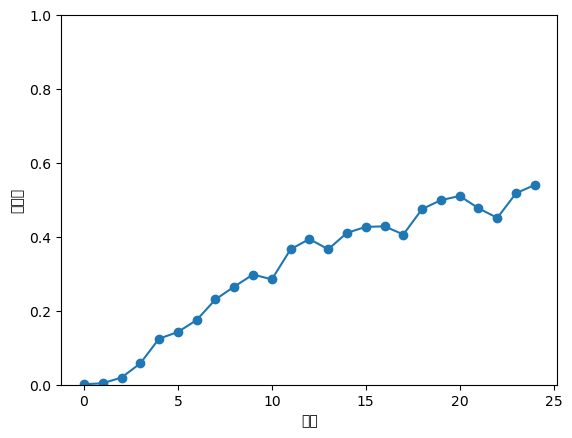

In [30]:
# coding: utf-8
import sys
sys.path.append('..')
import numpy as np
import matplotlib.pyplot as plt
from dataset import sequence
from common.optimizer import Adam
from common.trainer import Trainer
from common.util import eval_seq2seq


# 데이터셋 읽기
(x_train, t_train), (x_test, t_test) = sequence.load_data('addition.txt')
char_to_id, id_to_char = sequence.get_vocab()

# 입력 반전 여부 설정 =============================================
is_reverse = True
if is_reverse:
    x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]
# ================================================================

# 하이퍼파라미터 설정
vocab_size = len(char_to_id)
wordvec_size = 16
hidden_size = 128
batch_size = 128
max_epoch = 25
max_grad = 5.0

# 일반 혹은 엿보기(Peeky) 설정 =====================================
model = Seq2seq(vocab_size, wordvec_size, hidden_size)
# model = PeekySeq2seq(vocab_size, wordvec_size, hidden_size)
# ================================================================
optimizer = Adam()
trainer = Trainer(model, optimizer)

acc_list = []
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train, max_epoch=1,
                batch_size=batch_size, max_grad=max_grad)

    correct_num = 0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i < 10
        correct_num += eval_seq2seq(model, question, correct,
                                    id_to_char, verbose, is_reverse)

    acc = float(correct_num) / len(x_test)
    acc_list.append(acc)
    print('검증 정확도 %.3f%%' % (acc * 100))

# 그래프 그리기
x = np.arange(len(acc_list))
plt.plot(x, acc_list, marker='o')
plt.xlabel('에폭')
plt.ylabel('정확도')
plt.ylim(0, 1.0)
plt.show()


In [33]:
# coding: utf-8
import sys
sys.path.append('..')
from common.time_layers import *


class PeekyDecoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(H + D, 4 * H) / np.sqrt(H + D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(H + H, V) / np.sqrt(H + H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True)
        self.affine = TimeAffine(affine_W, affine_b)

        self.params, self.grads = [], []
        for layer in (self.embed, self.lstm, self.affine):
            self.params += layer.params
            self.grads += layer.grads
        self.cache = None

    def forward(self, xs, h):
        N, T = xs.shape
        N, H = h.shape

        self.lstm.set_state(h)

        out = self.embed.forward(xs)
        hs = np.repeat(h, T, axis=0).reshape(N, T, H)
        out = np.concatenate((hs, out), axis=2)

        out = self.lstm.forward(out)
        out = np.concatenate((hs, out), axis=2)

        score = self.affine.forward(out)
        self.cache = H
        return score

    def backward(self, dscore):
        H = self.cache

        dout = self.affine.backward(dscore)
        dout, dhs0 = dout[:, :, H:], dout[:, :, :H]
        dout = self.lstm.backward(dout)
        dembed, dhs1 = dout[:, :, H:], dout[:, :, :H]
        self.embed.backward(dembed)

        dhs = dhs0 + dhs1
        dh = self.lstm.dh + np.sum(dhs, axis=1)
        return dh

    def generate(self, h, start_id, sample_size):
        sampled = []
        char_id = start_id
        self.lstm.set_state(h)

        H = h.shape[1]
        peeky_h = h.reshape(1, 1, H)
        for _ in range(sample_size):
            x = np.array([char_id]).reshape((1, 1))
            out = self.embed.forward(x)

            out = np.concatenate((peeky_h, out), axis=2)
            out = self.lstm.forward(out)
            out = np.concatenate((peeky_h, out), axis=2)
            score = self.affine.forward(out)

            char_id = np.argmax(score.flatten())
            sampled.append(char_id)

        return sampled


class PeekySeq2seq(Seq2seq):
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        self.encoder = Encoder(V, D, H)
        self.decoder = PeekyDecoder(V, D, H)
        self.softmax = TimeSoftmaxWithLoss()

        self.params = self.encoder.params + self.decoder.params
        self.grads = self.encoder.grads + self.decoder.grads

| 에폭 1 |  반복 1 / 351 | 시간 0[s] | 손실 2.57
| 에폭 1 |  반복 21 / 351 | 시간 0[s] | 손실 2.48
| 에폭 1 |  반복 41 / 351 | 시간 0[s] | 손실 2.20
| 에폭 1 |  반복 61 / 351 | 시간 0[s] | 손실 1.99
| 에폭 1 |  반복 81 / 351 | 시간 1[s] | 손실 1.89
| 에폭 1 |  반복 101 / 351 | 시간 1[s] | 손실 1.82
| 에폭 1 |  반복 121 / 351 | 시간 1[s] | 손실 1.82
| 에폭 1 |  반복 141 / 351 | 시간 1[s] | 손실 1.80
| 에폭 1 |  반복 161 / 351 | 시간 2[s] | 손실 1.79
| 에폭 1 |  반복 181 / 351 | 시간 2[s] | 손실 1.78
| 에폭 1 |  반복 201 / 351 | 시간 2[s] | 손실 1.77
| 에폭 1 |  반복 221 / 351 | 시간 2[s] | 손실 1.76
| 에폭 1 |  반복 241 / 351 | 시간 3[s] | 손실 1.76
| 에폭 1 |  반복 261 / 351 | 시간 3[s] | 손실 1.75
| 에폭 1 |  반복 281 / 351 | 시간 3[s] | 손실 1.74
| 에폭 1 |  반복 301 / 351 | 시간 3[s] | 손실 1.74
| 에폭 1 |  반복 321 / 351 | 시간 4[s] | 손실 1.73
| 에폭 1 |  반복 341 / 351 | 시간 4[s] | 손실 1.73
Q 77+85  
T 162 
X 100 
---
Q 975+164
T 1139
X 1013
---
Q 582+84 
T 666 
X 102 
---
Q 8+155  
T 163 
X 100 
---
Q 367+55 
T 422 
X 1023
---
Q 600+257
T 857 
X 1023
---
Q 761+292
T 1053
X 1023
---
Q 830+597
T 1427
X 1111
---
Q 26+838

검증 정확도 65.060%
| 에폭 9 |  반복 1 / 351 | 시간 0[s] | 손실 0.32
| 에폭 9 |  반복 21 / 351 | 시간 0[s] | 손실 0.31
| 에폭 9 |  반복 41 / 351 | 시간 0[s] | 손실 0.31
| 에폭 9 |  반복 61 / 351 | 시간 0[s] | 손실 0.31
| 에폭 9 |  반복 81 / 351 | 시간 1[s] | 손실 0.29
| 에폭 9 |  반복 101 / 351 | 시간 1[s] | 손실 0.29
| 에폭 9 |  반복 121 / 351 | 시간 1[s] | 손실 0.29
| 에폭 9 |  반복 141 / 351 | 시간 1[s] | 손실 0.27
| 에폭 9 |  반복 161 / 351 | 시간 2[s] | 손실 0.27
| 에폭 9 |  반복 181 / 351 | 시간 2[s] | 손실 0.26
| 에폭 9 |  반복 201 / 351 | 시간 2[s] | 손실 0.25
| 에폭 9 |  반복 221 / 351 | 시간 2[s] | 손실 0.25
| 에폭 9 |  반복 241 / 351 | 시간 3[s] | 손실 0.24
| 에폭 9 |  반복 261 / 351 | 시간 3[s] | 손실 0.24
| 에폭 9 |  반복 281 / 351 | 시간 3[s] | 손실 0.23
| 에폭 9 |  반복 301 / 351 | 시간 3[s] | 손실 0.22
| 에폭 9 |  반복 321 / 351 | 시간 3[s] | 손실 0.22
| 에폭 9 |  반복 341 / 351 | 시간 4[s] | 손실 0.21
Q 77+85  
T 162 
O 162 
---
Q 975+164
T 1139
X 1140
---
Q 582+84 
T 666 
X 657 
---
Q 8+155  
T 163 
O 163 
---
Q 367+55 
T 422 
O 422 
---
Q 600+257
T 857 
O 857 
---
Q 761+292
T 1053
O 1053
---
Q 830+597
T 1427
O 14

| 에폭 16 |  반복 301 / 351 | 시간 3[s] | 손실 0.03
| 에폭 16 |  반복 321 / 351 | 시간 3[s] | 손실 0.03
| 에폭 16 |  반복 341 / 351 | 시간 4[s] | 손실 0.04
Q 77+85  
T 162 
O 162 
---
Q 975+164
T 1139
O 1139
---
Q 582+84 
T 666 
O 666 
---
Q 8+155  
T 163 
O 163 
---
Q 367+55 
T 422 
O 422 
---
Q 600+257
T 857 
O 857 
---
Q 761+292
T 1053
O 1053
---
Q 830+597
T 1427
O 1427
---
Q 26+838 
T 864 
O 864 
---
Q 143+93 
T 236 
O 236 
---
검증 정확도 96.780%
| 에폭 17 |  반복 1 / 351 | 시간 0[s] | 손실 0.04
| 에폭 17 |  반복 21 / 351 | 시간 0[s] | 손실 0.03
| 에폭 17 |  반복 41 / 351 | 시간 0[s] | 손실 0.03
| 에폭 17 |  반복 61 / 351 | 시간 0[s] | 손실 0.03
| 에폭 17 |  반복 81 / 351 | 시간 1[s] | 손실 0.03
| 에폭 17 |  반복 101 / 351 | 시간 1[s] | 손실 0.02
| 에폭 17 |  반복 121 / 351 | 시간 1[s] | 손실 0.02
| 에폭 17 |  반복 141 / 351 | 시간 1[s] | 손실 0.02
| 에폭 17 |  반복 161 / 351 | 시간 1[s] | 손실 0.02
| 에폭 17 |  반복 181 / 351 | 시간 2[s] | 손실 0.02
| 에폭 17 |  반복 201 / 351 | 시간 2[s] | 손실 0.03
| 에폭 17 |  반복 221 / 351 | 시간 2[s] | 손실 0.03
| 에폭 17 |  반복 241 / 351 | 시간 2[s] | 손실 0.03
| 에폭 17

| 에폭 24 |  반복 101 / 351 | 시간 1[s] | 손실 0.02
| 에폭 24 |  반복 121 / 351 | 시간 1[s] | 손실 0.01
| 에폭 24 |  반복 141 / 351 | 시간 1[s] | 손실 0.02
| 에폭 24 |  반복 161 / 351 | 시간 1[s] | 손실 0.01
| 에폭 24 |  반복 181 / 351 | 시간 2[s] | 손실 0.01
| 에폭 24 |  반복 201 / 351 | 시간 2[s] | 손실 0.01
| 에폭 24 |  반복 221 / 351 | 시간 2[s] | 손실 0.01
| 에폭 24 |  반복 241 / 351 | 시간 2[s] | 손실 0.01
| 에폭 24 |  반복 261 / 351 | 시간 3[s] | 손실 0.01
| 에폭 24 |  반복 281 / 351 | 시간 3[s] | 손실 0.01
| 에폭 24 |  반복 301 / 351 | 시간 3[s] | 손실 0.01
| 에폭 24 |  반복 321 / 351 | 시간 3[s] | 손실 0.01
| 에폭 24 |  반복 341 / 351 | 시간 4[s] | 손실 0.01
Q 77+85  
T 162 
O 162 
---
Q 975+164
T 1139
O 1139
---
Q 582+84 
T 666 
O 666 
---
Q 8+155  
T 163 
O 163 
---
Q 367+55 
T 422 
O 422 
---
Q 600+257
T 857 
O 857 
---
Q 761+292
T 1053
O 1053
---
Q 830+597
T 1427
O 1427
---
Q 26+838 
T 864 
O 864 
---
Q 143+93 
T 236 
O 236 
---
검증 정확도 98.940%
| 에폭 25 |  반복 1 / 351 | 시간 0[s] | 손실 0.01
| 에폭 25 |  반복 21 / 351 | 시간 0[s] | 손실 0.01
| 에폭 25 |  반복 41 / 351 | 시간 0[s] | 손실 0.01
| 에폭 

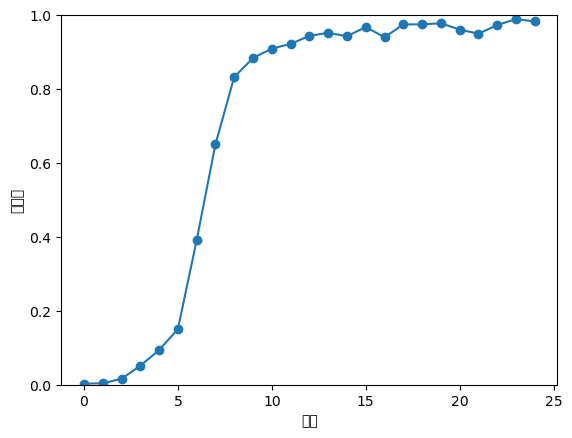

In [34]:
# coding: utf-8
import sys
sys.path.append('..')
import numpy as np
import matplotlib.pyplot as plt
from dataset import sequence
from common.optimizer import Adam
from common.trainer import Trainer
from common.util import eval_seq2seq


# 데이터셋 읽기
(x_train, t_train), (x_test, t_test) = sequence.load_data('addition.txt')
char_to_id, id_to_char = sequence.get_vocab()

# 입력 반전 여부 설정 =============================================
is_reverse = True
if is_reverse:
    x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]
# ================================================================

# 하이퍼파라미터 설정
vocab_size = len(char_to_id)
wordvec_size = 16
hidden_size = 128
batch_size = 128
max_epoch = 25
max_grad = 5.0

# 일반 혹은 엿보기(Peeky) 설정 =====================================
#model = Seq2seq(vocab_size, wordvec_size, hidden_size)
model = PeekySeq2seq(vocab_size, wordvec_size, hidden_size)
# ================================================================
optimizer = Adam()
trainer = Trainer(model, optimizer)

acc_list = []
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train, max_epoch=1,
                batch_size=batch_size, max_grad=max_grad)

    correct_num = 0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i < 10
        correct_num += eval_seq2seq(model, question, correct,
                                    id_to_char, verbose, is_reverse)

    acc = float(correct_num) / len(x_test)
    acc_list.append(acc)
    print('검증 정확도 %.3f%%' % (acc * 100))

# 그래프 그리기
x = np.arange(len(acc_list))
plt.plot(x, acc_list, marker='o')
plt.xlabel('에폭')
plt.ylabel('정확도')
plt.ylim(0, 1.0)
plt.show()
